In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Load input data
challenge_set =pd.read_csv("challenge_set_addParq.csv")
challenge_set.head()
final_submission_set =pd.read_csv("final_submission_set_addParq.csv")
final_submission_set.head()

,Unnamed: 0,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,...,arrival_time,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,tow,ICA,maxAlt
0,0,248753821,2022-01-01,3b3de0f3ad0ee192513995c02f7bf7cf,LTFJ,Istanbul Sabiha Gokcen,TR,LFLL,Lyon,FR,...,2022-01-01T12:48:33Z,B738,M,6351ec1b849adacc0cbb3b1313d8d39b,170,15,1122,NaN,36000.00,36025.0
1,1,248753822,2022-01-01,e06dd03d4a879ca37d9e18c1bd7cad16,EBBR,Brussels,BE,KJFK,New York JFK,US,...,2022-01-01T17:49:51Z,A333,H,bdeeef3a675587d530de70a25d7118d2,470,15,3205,NaN,36000.00,40000.0
2,2,248754498,2022-01-01,2d3b1c962c78c4ebeef11bcd51b9e94c,KMIA,Miami,US,EGLL,London Heathrow,GB,...,2022-01-01T09:55:16Z,B77W,H,5543e4dc327359ffaf5b9c0e6faaf0e1,473,10,3965,NaN,34632.25,35000.0
3,3,248763650,2022-01-01,35f7721f68bf85128195547ae38b0f04,EBBR,Brussels,BE,LEAL,Alicante,ES,...,2022-01-01T14:13:56Z,B738,M,f53c55b5cf0cbb3be755bf50df6fa52d,123,9,802,NaN,35000.00,39000.0
4,4,248763651,2022-01-01,eb56918bee9bc5204624186b9bcc4391,LSZH,Zurich,CH,LFPG,Paris Charles de Gaulle,FR,...,2022-01-01T13:09:44Z,BCS3,M,2d5def0a5a844b343ba1b7cc9cb28fa9,56,11,292,NaN,11925.00,31000.0


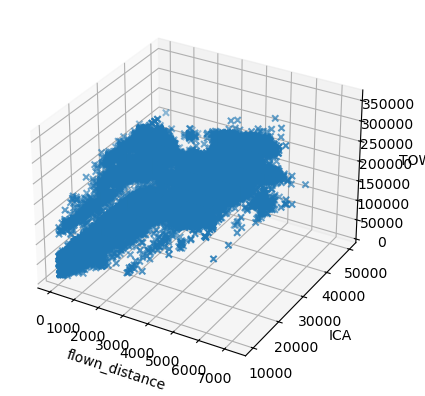

In [3]:
# Visualise input data set
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = challenge_set["flown_distance"]
ys = challenge_set["ICA"]
zs = challenge_set["tow"]
ax.scatter(xs, ys, zs, marker='x')

ax.set_xlabel('flown_distance')
ax.set_ylabel('ICA')
ax.set_zlabel('TOW')

plt.show()

# # Plot TrainData TOW vs FlownDist
# plt.scatter(challenge_set["flown_distance"],challenge_set["tow"])
# plt.grid('minor')
# plt.xlabel('flown_distance (nm)')
# plt.ylabel('TOW (kg)')
# plt.title('Train Data')
# plt.show()

In [5]:
# ---------------Version 10---------------
# Create dummy min TOW for each ACtype group for ExtraTrees.
train_group_by_ac = challenge_set.groupby("aircraft_type")
min_tow_by_ac = train_group_by_ac.min()
# print(min_tow_by_ac)
ac_tows = min_tow_by_ac["tow"].values
ac_list = min_tow_by_ac["tow"].index.values
type_dic = {}
for i in range(len(ac_tows)):
    type_dic[ac_list[i]] = ac_tows[i]
challenge_set["actype_mintow"] = challenge_set["aircraft_type"].map(type_dic)

train_df = challenge_set[["actype_mintow","flight_duration","flown_distance","taxiout_time","tow"]]
X = train_df[["flight_duration","flown_distance","taxiout_time","actype_mintow"]].to_numpy()
y = train_df["tow"].to_numpy()

# ExtraTreeRegression with Train Test Split
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    # ExTreeReg_Sample = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)
    # score = cross_val_score(ExTreeReg_Sample, X_test, y_test, scoring='neg_root_mean_squared_error').mean().round(2)
    # print("Train Test Split cross val score is: ",score)
# cross val score is:  -5866.8

# ExtraTreeRegression with All Train Data
ExTreeReg_All = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X, y)
training_set_pred = ExTreeReg_All.predict(X)
score = cross_val_score(ExTreeReg_All, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("All Train Data cross val score is: ",score)
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)
# cross val score is: -6147.41

# Pred Submission Set (v10)
final_submission_set["actype_mintow"] = final_submission_set["aircraft_type"].map(type_dic)
submi_df = final_submission_set[["actype_mintow","flight_duration","flown_distance","taxiout_time"]]
X = submi_df[["flight_duration","flown_distance","taxiout_time","actype_mintow"]].to_numpy()
final_submission_set_pred = ExTreeReg_All.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set.to_csv("final_submission_set_ExTreeReg_All.csv")
### RMSE score on OSN Ranking = 5764.1

All Train Data cross val score is:  -6147.41


OSError: [Errno 22] Invalid argument: 'ExtraTreesOutput\x0cinal_submission_set_ExTreeReg_All.csv'

In [6]:
# ---------------Version 11---------------
# # Create dummy min TOW for each ACtype/Airline group for ExtraTrees. (Step 1)
tow_by_acOp = challenge_set.groupby(["aircraft_type", "airline"])
tow_by_ac = challenge_set.groupby(["aircraft_type"])
group_by_acOp = tow_by_acOp[["actype_mintow","flight_duration","flown_distance","taxiout_time","tow","tow_diff"]]
group_by_ac = tow_by_ac[["actype_mintow","flight_duration","flown_distance","taxiout_time","tow","tow_diff"]]
# group_by_acOp.head(5)
mean_group_by_acOp = group_by_acOp.mean()
mean_group_by_ac = group_by_ac.mean()
# print(mean_group_by_acOp)
acOp_tows = mean_group_by_acOp["tow"].values
acOp_list = mean_group_by_acOp["tow"].index.values
ac_tows = mean_group_by_ac["tow"].values
ac_list = mean_group_by_ac["tow"].index.values
# print(acOp_list)
acOp_dic = {}
for i in range(len(acOp_list)):
    acOp_dic[acOp_list[i]] = acOp_tows[i]
ac_dic = {}
for i in range(len(ac_list)):
    ac_dic[ac_list[i]] = ac_tows[i]
challenge_set['acOp'] = challenge_set[['aircraft_type', 'airline']].apply(tuple, axis=1)
challenge_set["acOp_meantow"] = challenge_set["acOp"].map(acOp_dic)
# print(challenge_set[["acOp","acOp_meantow"]])

# Create dummy min TOW for each ACtype/Airline group for ExtraTrees. (Step 2)
train_df = challenge_set[["actype_mintow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_mintow"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with All Train Data
ExTreeReg_acOp = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X, y)
training_set_pred = ExTreeReg_acOp.predict(X)
score = cross_val_score(ExTreeReg_acOp, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  -5083.28
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

# ACtype/Airline group Pred Submission Set  (Step 3) (v11)
final_submission_set["actype_mintow"] = final_submission_set["aircraft_type"].map(type_dic)
# final_submission_set["actype_meantow"] = final_submission_set["aircraft_type"].map(ac_dic)
final_submission_set['acOp'] = final_submission_set[['aircraft_type', 'airline']].apply(tuple, axis=1)
final_submission_set["acOp_meantow"] = final_submission_set["acOp"].map(acOp_dic)
# print(final_submission_set["acOp_meantow"])
# print(final_submission_set["acOp_meantow"].isna().sum())
# print(final_submission_set.loc[final_submission_set["acOp_meantow"].isna(), ["acOp_meantow"]])
# print(final_submission_set.loc[[28098,78003,102792], ["acOp_meantow"]])
# print(final_submission_set["actype_meantow"])
# final_submission_set.loc[final_submission_set["acOp_meantow"].isna(), ["acOp_meantow"]] = final_submission_set.loc[final_submission_set["acOp_meantow"].isna(), ["actype_meantow"]]
final_submission_set.loc[final_submission_set["acOp_meantow"].isna(), ["acOp_meantow"]] = 79482.25723 # Average TOW of all training set (only 3 lines from final_submission_set is affected..)
print(final_submission_set.loc[[28098,78003,102792], ["acOp_meantow"]])
# print(final_submission_set)
submi_df = final_submission_set[["actype_mintow","acOp_meantow","flight_duration","flown_distance","taxiout_time"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_mintow"]].to_numpy()
final_submission_set_pred = ExTreeReg_acOp.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set.to_csv("final_submission_set_ExTreeReg_acOp.csv")
### RMSE score on OSN Ranking = 

cross val score is:  -5083.28
        acOp_meantow
28098    79482.25723
78003    79482.25723
102792   79482.25723


In [20]:
# ---------------Version 12---------------
# # Create dummy min TOW for each ACtype/Airline group for ExtraTrees. (Step 1)
tow_by_acOp = challenge_set.groupby(["aircraft_type", "airline"])
tow_by_ac = challenge_set.groupby(["aircraft_type"])
group_by_acOp = tow_by_acOp[["actype_mintow","flight_duration","flown_distance","taxiout_time","tow","tow_diff"]]
group_by_ac = tow_by_ac[["actype_mintow","flight_duration","flown_distance","taxiout_time","tow","tow_diff","ICA","maxAlt"]]
mean_group_by_acOp = group_by_acOp.mean()
mean_group_by_ac = group_by_ac.mean()
# print(mean_group_by_acOp)
acOp_tows = mean_group_by_acOp["tow"].values
acOp_list = mean_group_by_acOp["tow"].index.values
ac_tows = mean_group_by_ac["tow"].values
ac_ICAs = mean_group_by_ac["ICA"].values
ac_maxAlts = mean_group_by_ac["maxAlt"].values
ac_list = mean_group_by_ac["tow"].index.values
# print(acOp_list)
acOp_dic = {}
for i in range(len(acOp_list)):
    acOp_dic[acOp_list[i]] = acOp_tows[i]
ac_dic = {}
acICA_dic = {}
acmxAlt_dic = {}
for i in range(len(ac_list)):
    ac_dic[ac_list[i]] = ac_tows[i]
    acICA_dic[ac_list[i]] = ac_ICAs[i]
    acmxAlt_dic[ac_list[i]] = ac_maxAlts[i]
# print(ac_dic)
challenge_set['acOp'] = challenge_set[['aircraft_type', 'airline']].apply(tuple, axis=1)
challenge_set["acOp_meantow"] = challenge_set["acOp"].map(acOp_dic)
challenge_set["actype_meanICA"] = challenge_set["aircraft_type"].map(acICA_dic)
challenge_set["actype_meanmaxAlt"] = challenge_set["aircraft_type"].map(acmxAlt_dic)
# print(challenge_set[["acOp","acOp_meantow"]])

challenge_set.loc[challenge_set["ICA"].isna(), ["ICA"]] = 35000
challenge_set.loc[challenge_set["maxAlt"].isna(), ["maxAlt"]] = 38000
# challenge_set.loc[challenge_set["ICA"].isna(), ["ICA"]].replace(challenge_set.loc[challenge_set["ICA"].isna(), ["actype_meanICA"]])
# challenge_set.loc[challenge_set["maxAlt"].isna(), ["maxAlt"]] = challenge_set.loc[challenge_set["maxAlt"].isna(), ["actype_meanmaxAlt"]]
print(challenge_set.loc[challenge_set["maxAlt"].isna(), ["ICA", "maxAlt", "actype_meanICA", "actype_meanmaxAlt"]])

Empty DataFrame
Columns: [ICA, maxAlt, actype_meanICA, actype_meanmaxAlt]
Index: []


In [23]:
# ---------------Version 12 (section 2) ---------------
# Create dummy min TOW for each ACtype/Airline group for ExtraTrees. (Step 2)
train_df = challenge_set[["actype_mintow","acOp_meantow","flight_duration","flown_distance","taxiout_time","tow","ICA","maxAlt"]]
X = train_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_mintow","ICA","maxAlt"]].to_numpy()
y = train_df["tow"].to_numpy()
# ExtraTreeRegression with 7 Parameters: "actype_mintow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt"
ExTreeReg_7Param = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X, y)
training_set_pred = ExTreeReg_7Param.predict(X)
score = cross_val_score(ExTreeReg_7Param, X, y, scoring='neg_root_mean_squared_error').mean().round(2)
print("cross val score is: ",score)
# cross val score is:  -4095.77
challenge_set["tow_pred"] = training_set_pred
challenge_set["tow_diff"] = challenge_set["tow_pred"].sub(challenge_set["tow"], axis=0)

# ACtype/Airline group Pred Submission Set  (Step 3) (v11)
final_submission_set["actype_mintow"] = final_submission_set["aircraft_type"].map(type_dic)
# final_submission_set["actype_meantow"] = final_submission_set["aircraft_type"].map(ac_dic)
final_submission_set['acOp'] = final_submission_set[['aircraft_type', 'airline']].apply(tuple, axis=1)
final_submission_set["acOp_meantow"] = final_submission_set["acOp"].map(acOp_dic)
final_submission_set.loc[final_submission_set["acOp_meantow"].isna(), ["acOp_meantow"]] = 79482.25723 # Average TOW of all training set (only 3 lines from final_submission_set is affected..)
final_submission_set.loc[final_submission_set["ICA"].isna(), ["ICA"]] = 35000
final_submission_set.loc[final_submission_set["maxAlt"].isna(), ["maxAlt"]] = 38000

submi_df = final_submission_set[["actype_mintow","acOp_meantow","flight_duration","flown_distance","taxiout_time","ICA","maxAlt"]]
X = submi_df[["flight_duration","acOp_meantow","flown_distance","taxiout_time","actype_mintow","ICA","maxAlt"]].to_numpy()
final_submission_set_pred = ExTreeReg_7Param.predict(X)
final_submission_set["tow"] = final_submission_set_pred
final_submission_set[["flight_id","tow"]].to_csv("final_submission_set_ExTreeReg_7Param.csv",index=False)
### RMSE score on OSN Ranking = 

KeyboardInterrupt: 

In [25]:
print(final_submission_set[["flight_id","tow"]])

        flight_id            tow
0       248753821   67479.730000
1       248753822  213378.335815
2       248754498  229997.000000
3       248763650   65735.360000
4       248763651   53541.130000
...           ...            ...
158144  258068876   74684.190000
158145  258064675   59495.989003
158146  258065436  192563.450000
158147  258058138   38816.000000
158148  258058370   64152.380000

[158149 rows x 2 columns]


In [14]:
des_ap = df.groupby("adep")
mean_deviation_by_ap = des_ap.mean()
ap_devs = mean_deviation_by_ap["tow_diff"].values
ap_list = mean_deviation_by_ap["tow_diff"].index.values
des_dic = {}
for i in range(len(ap_devs)):
    des_dic[ap_list[i]] = ap_devs[i]
#print(ap_devs)
#print(ap_list)
#print(des_dic)
df["des_dev"] = df["adep"].map(des_dic)

In [15]:
df.head()

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,wtc,airline,flight_duration,taxiout_time,flown_distance,tow,ac_tow,tow_pred,tow_diff,des_dev
0,248763780,2022-01-01,3840d84f25d3f5fcc0a1be3076bb4039,EGLL,London Heathrow,GB,EICK,Cork,IE,2022-01-01T13:46:00Z,...,M,a73f82288988b79be490c6322f4c32ed,61,18,321,54748.000000,44861.0,58602.000000,3.854000e+03,179.415784
1,248760618,2022-01-01,f6f610e73002b8892a239a81321f7f1d,LEBL,Barcelona,ES,KMIA,Miami,US,2022-01-01T09:55:00Z,...,H,5543e4dc327359ffaf5b9c0e6faaf0e1,570,13,4193,185441.000000,150327.0,185441.000000,0.000000e+00,91.354470
2,248753824,2022-01-01,139670936660762c230ca92556ba842b,ESSA,Stockholm Arlanda,SE,KORD,Chicago O'Hare,US,2022-01-01T09:39:00Z,...,H,8be5c854fd664bcb97fb543339f74770,554,15,3770,230396.000000,134373.0,230396.000000,0.000000e+00,47.588029
3,248753852,2022-01-01,509dc61bb54fbab0e5406067c95603e2,LSZH,Zurich,CH,KPHL,Philadelphia,US,2022-01-01T11:04:00Z,...,H,5543e4dc327359ffaf5b9c0e6faaf0e1,497,11,3607,157615.000000,118668.0,157615.000000,0.000000e+00,-142.809600
4,248755934,2022-01-01,d0610d000dcf26b1d7bba8103ecc393d,EIDW,Dublin,IE,EGLL,London Heathrow,GB,2022-01-01T12:36:00Z,...,M,a73f82288988b79be490c6322f4c32ed,55,14,305,70318.447226,56806.0,70318.447226,3.929017e-10,149.919165


In [16]:
df1 = df[["ac_tow","flight_duration","flown_distance","taxiout_time","des_dev","tow"]]
X = df1[["flight_duration","flown_distance","taxiout_time","ac_tow","des_dev"]].to_numpy()
y = df1["tow"].to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)
reg = ExtraTreesRegressor(n_estimators=500, random_state=0).fit(
   X_train, y_train)
reg.score(X_test, y_test)

In [ ]:
df_sub=pd.read_csv("final_submission_set.csv")

df_sub["min_ac_tow"] = df_sub["aircraft_type"].map(type_dic)

df_sub["des_dev"] = df_sub["ades"].map(des_dic)

df_sub.head()

df_sub.to_csv("half_processed_sub.csv")


In [ ]:
df_sub["des_dev"].sum()
df_sub["des_dev"]=df_sub["des_dev"].fillna(0)

In [ ]:
df_pred = df_sub[["min_ac_tow","flight_duration","flown_distance","taxiout_time","des_dev"]]

X1 = df_pred[["flight_duration","flown_distance","taxiout_time","min_ac_tow","des_dev"]].to_numpy()

tow_pred = reg.predict(X1)

df_sub["tow"] = tow_pred

df_sub = df_sub.filter(["flight_id","tow"])

df_sub.to_csv("Final_Submissions_Extra_Trees_v9.csv", index=False)

In [ ]:
from matplotlib import pyplot as plt

plt.scatter(df_sub["flight_id"],df_sub["tow"])